In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [25]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

In [26]:
len(df_all)

701667

In [27]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [28]:
df_all.head(2)

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Term_novelty,Topic_novelty,Freq_relationship,Category_F_F,...,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_homestuck,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
0,2,1.0,3,0,320.0,8.0,0.778655,0.599456,0,0,...,0,0,0,0,0,0,0,0,0,5136.0
1,0,0.0,1,0,25.0,1.0,0.713975,0.605999,0,0,...,0,0,0,0,0,0,0,0,0,5589.0


### Logistic

In [29]:
df_all['Intercept'] = 1.0

In [30]:
df_all['kudos_binary'] = df_all['Kudos'].apply(lambda x: 1 if x != 0.0 else 0)

In [31]:
df_all['kudos_binary'].value_counts()

1    689373
0     12294
Name: kudos_binary, dtype: int64

In [32]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all.dropna(how = 'any')

In [33]:
len(df_all)

701667

In [34]:
logit_model = sm.Logit(df_all["kudos_binary"], df_all[['ChapterIndex', 'Chapters',\
        'Term_novelty', 'Topic_novelty', \
        'Freq_relationship', 'Category_F_M',\
       'Category_Gen', 'Category_M_M', 'Category_Multi', 'Category_Other','Category_Unknown', \
       'ArchiveWarnings_underage', 'ArchiveWarnings_death',\
       'ArchiveWarnings_choose_no', 'ArchiveWarnings_no_apply',\
       'ArchiveWarnings_violence',\
       'ArchiveWarnings_noncon', 'author_fic_cnt', 'Rating_G',\
       'Rating_M', 'Rating_N', 'Rating_T',\
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History', 'Intercept']]).fit(method='bfgs')

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:

         Current function value: 0.078306
         Iterations: 35
         Function evaluations: 72
         Gradient evaluations: 54


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [35]:
# logit_model.summary()

In [36]:
pred = logit_model.predict()

In [37]:
sorted(pred)

[0.671199793259975,
 0.6749320295372575,
 0.6764323165713734,
 0.6861868346374426,
 0.6862078966794957,
 0.6890149809713801,
 0.6908750911545377,
 0.6950285067939013,
 0.6974576503105757,
 0.7023756873066507,
 0.7036074011855676,
 0.7059843557045112,
 0.7103671193866494,
 0.7113738646805147,
 0.7121648682312302,
 0.7125056075290633,
 0.7135191113957705,
 0.7139707475772233,
 0.7145680710240584,
 0.7150399862969605,
 0.7159054563221946,
 0.7164065005611417,
 0.7176315612569898,
 0.7189709705402993,
 0.721081333750856,
 0.7236319125460356,
 0.7243890226080293,
 0.72458808091798,
 0.7260756256971423,
 0.727538154897299,
 0.7299257468577212,
 0.7299707544461727,
 0.731708533316135,
 0.732004985009554,
 0.7320508330013917,
 0.7320615796776867,
 0.7330324102714784,
 0.7345363549155687,
 0.7346045668601715,
 0.7349746661923087,
 0.7352127173301984,
 0.735508826166546,
 0.7370276491038517,
 0.7381479221997216,
 0.7390962046757421,
 0.7392170520170843,
 0.7394326826539395,
 0.740373539250574,
 

In [38]:
df_all['kudos_nonzero_prob'] = pred

### OLS

In [39]:
df_all_log = df_all.copy()
df_all_log['Kudos'] = np.log(df_all_log['Kudos']+0.001)
df_all_log['Hits'] = np.log(df_all_log['Hits']+0.001)
df_all_log['Comments'] = np.log(df_all_log['Comments']+1)
df_all_log['Bookmarks'] = np.log(df_all_log['Bookmarks']+0.001)
df_all_log = df_all_log.replace([np.inf, -np.inf], np.nan)
df_all_log = df_all_log.dropna(how = 'any')

In [40]:
# s = ''
# for item in df_all.columns.values:
#     s += item + ' + '

In [46]:
model = ols("Kudos ~ Term_novelty + Topic_novelty \
 + Chapters + Freq_relationship + author_fic_cnt  + ChapterIndex\
 + Category_F_M + Category_Gen + Category_M_M + Category_Multi + Category_Other + Category_Unknown \
 + ArchiveWarnings_underage + ArchiveWarnings_death + ArchiveWarnings_choose_no +\
 ArchiveWarnings_no_apply  + ArchiveWarnings_violence +\
 ArchiveWarnings_noncon + Rating_E + Rating_M + Rating_N + Rating_T\
 + Fandom_dcu + Fandom_doctor_who + Fandom_star_wars + Fandom_arthurian + \
 Fandom_supernatural + Fandom_haikyuu + Fandom_kuroko_no_basuke + Fandom_hamilton_miranda\
 + Fandom_dragon_age + Fandom_the_walking_dead + Fandom_buffy + Fandom_les_miserables \
 + Fandom_naruto + Fandom_tolkien + Fandom_shakespare + Fandom_hetalia + \
 Fandom_attack_on_titan + Fandom_ms_paint_adventures + Fandom_homestuck +\
 Fandom_marvel + Fandom_sailor_moon + Fandom_one_direction + Fandom_sherlock \
 + History + kudos_nonzero_prob", data = df_all_log).fit()

In [47]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Kudos   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     5456.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        16:14:34   Log-Likelihood:            -1.3944e+06
No. Observations:              701667   AIC:                         2.789e+06
Df Residuals:                  701620   BIC:                         2.789e+06
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [325]:
# for item in ['Term_novelty', 'Topic_novelty']:
#     fig = plt.figure(figsize=(12,8))
#     fig = sm.graphics.plot_regress_exog(model, item, fig=fig)


### Plot coefficients

In [50]:
ylabels = ['Term_novelty ',' Topic_novelty \
 ',' Chapters ',' Freq_relationship ',' author_fic_cnt ',' History ',\
' Category_F_M ',' Category_Gen ',' Category_M_M ',' Category_Multi ',' Category_Other ',' Category_Unknown \
 ',' ArchiveWarnings_underage ',' ArchiveWarnings_death ',' ArchiveWarnings_choose_no ','\
 ArchiveWarnings_no_apply  ',' ArchiveWarnings_violence ','\
 ArchiveWarnings_noncon ',' Rating_E ',' Rating_M ',' Rating_N ',' Rating_T\
 ',' Fandom_dcu ',' Fandom_doctor_who ',' Fandom_star_wars ',' Fandom_arthurian ',' \
 Fandom_supernatural ',' Fandom_haikyuu ',' Fandom_kuroko_no_basuke ',' Fandom_hamilton_miranda\
 ',' Fandom_dragon_age ',' Fandom_the_walking_dead ',' Fandom_buffy ',' Fandom_les_miserables \
 ',' Fandom_naruto ',' Fandom_tolkien ',' Fandom_shakespare ',' Fandom_hetalia ',' \
 Fandom_attack_on_titan ',' Fandom_ms_paint_adventures ',' Fandom_homestuck ','\
 Fandom_marvel ',' Fandom_sailor_moon ',' Fandom_one_direction ',' Fandom_sherlock']

In [51]:
kudos_coef = [-0.7892,-2.4062,0.0110,0.3325,-7.516e-06,-0.0001,-0.2264,3.281e-05, 0.1078,\
             0.0315, -0.3563, -0.2223 , 0.2215 , -0.3268 ,  -0.0879 , -0.0980, -0.1730, 0.2143,\
             0.8249, 0.3580, 0.1016, 0.1239, -0.2930, -0.2930, 0.1082, -0.1814, -0.4136, 0.4002, 0.2901, 0.3397, \
             -0.1602, 0.1056, -0.9401, -0.1667, -0.4074, 0.0626, -0.8399, -0.6205, -0.0181, 0.1921, 0.2148, 0.5203, \
             -1.7978, -0.5417, 0.0052]

[Text(0,0,'Term_novelty '),
 Text(0,0,' Topic_novelty  '),
 Text(0,0,' Chapters '),
 Text(0,0,' Freq_relationship '),
 Text(0,0,' author_fic_cnt '),
 Text(0,0,' History '),
 Text(0,0,' kudos_nonzero_prob '),
 Text(0,0,' Category_F_M '),
 Text(0,0,' Category_Gen '),
 Text(0,0,' Category_M_M '),
 Text(0,0,' Category_Multi '),
 Text(0,0,' Category_Other '),
 Text(0,0,' Category_Unknown  '),
 Text(0,0,' ArchiveWarnings_underage '),
 Text(0,0,' ArchiveWarnings_death '),
 Text(0,0,' ArchiveWarnings_choose_no '),
 Text(0,0,' ArchiveWarnings_no_apply  '),
 Text(0,0,' ArchiveWarnings_violence '),
 Text(0,0,' ArchiveWarnings_noncon '),
 Text(0,0,' Rating_E '),
 Text(0,0,' Rating_M '),
 Text(0,0,' Rating_N '),
 Text(0,0,' Rating_T '),
 Text(0,0,' Fandom_dcu '),
 Text(0,0,' Fandom_doctor_who '),
 Text(0,0,' Fandom_star_wars '),
 Text(0,0,' Fandom_arthurian '),
 Text(0,0,'  Fandom_supernatural '),
 Text(0,0,' Fandom_haikyuu '),
 Text(0,0,' Fandom_kuroko_no_basuke '),
 Text(0,0,' Fandom_hamilton_mir

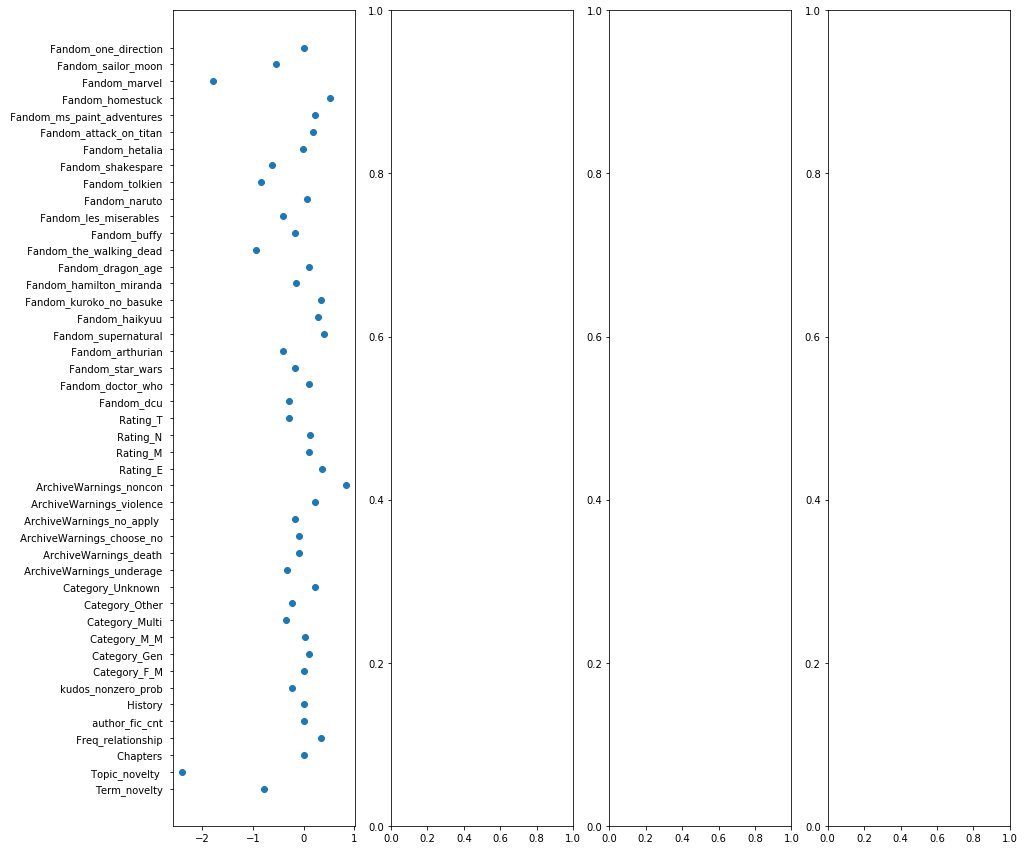

In [58]:
fig, ax = plt.subplots(1,4,figsize = (15,15))

ax[0].scatter(kudos_coef, range(len(kudos_coef)))
ax[0].set_yticks(range(len(kudos_coef)))
ax[0].set_yticklabels(ylabels)